In [1]:
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
  
if IN_COLAB:
    # Mount the Google Drive at mount
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os
    drive_root = mount + "/My Drive/ML_for_fun/Stock prediction/Data"
    
    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok = True)
    
    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
else:
    raise RuntimeError("This notebook should be run from Colab, not on the local machine")

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/ML_for_fun/Stock prediction/Data  exists.

Colab: Changing directory to  /content/gdrive/My Drive/ML_for_fun/Stock prediction/Data
/content/gdrive/My Drive/ML_for_fun/Stock prediction/Data


# Data preparation

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [3]:
from keras.layers import Dense,Dropout,Input,Flatten,Concatenate,Conv1D,LSTM

In [4]:
aapl=pd.read_csv('./AAPL.csv')
def prepare_dat(df):
  df2=df.copy()
  df2.set_index('Date',inplace=True)
  df2.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)
  return df2
aapl2=prepare_dat(aapl)
def create_lags(df,column,num):
  df2=df.copy()
  for i in range(1,num):
    df2[column+str(-i)]=df2[column].shift(i)
  df2.dropna(inplace=True)
  return df2 
X=create_lags(aapl2,'Adj Close',6)

In [5]:
X.dropna(inplace=True)
y=X['Adj Close'].pct_change()
y.dropna(inplace=True)
X=X.drop('Adj Close',axis=1).pct_change()
y_cl=(y.values>0).astype(int)
y_reg=y.values

# Classification

In [6]:
Xtrain,Xval,Xtest,ytrain,yval,ytest=X.iloc[:3000,:],X.iloc[3000:3500,:],X.iloc[3500:,:],y_cl[:3000],y_cl[3000:3500],y_cl[3500:]

In [7]:
Xtrain.dropna(inplace=True)
Xval.dropna(inplace=True)
Xtest.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [8]:
Xtrain,Xval,Xtest=Xtrain.values,Xval.values,Xtest.values

In [9]:
ytrain=ytrain[1:]

In [10]:
Xtest=Xtest[:-1]

In [11]:
Xtrain,Xval,Xtest=Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1),Xval.reshape(Xval.shape[0],Xval.shape[1],1),Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)

In [12]:
simple_dense=keras.models.Sequential([Flatten(input_shape=[5,1]),
                                      Dense(20,activation='relu'),
                                      Dense(1, activation='sigmoid')
])

In [13]:
simple_dense.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
history=simple_dense.fit(Xtrain,ytrain,epochs=20,validation_data=(Xval,yval))

Epoch 1/20
94/94 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.5238 - val_loss: 0.6911 - val_accuracy: 0.5380
Epoch 2/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5242 - val_loss: 0.6909 - val_accuracy: 0.5380
Epoch 3/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5242 - val_loss: 0.6904 - val_accuracy: 0.5380
Epoch 4/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5238 - val_loss: 0.6901 - val_accuracy: 0.5380
Epoch 5/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5245 - val_loss: 0.6901 - val_accuracy: 0.5380
Epoch 6/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5252 - val_loss: 0.6900 - val_accuracy: 0.5380
Epoch 7/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5242 - val_loss: 0.6902 - val_accuracy: 0.5380
Epoch 8/20
94/94 [==

In [15]:
simple_dense.evaluate(Xtest,ytest)

20/20 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.5538


[0.688881516456604, 0.5537974834442139]

In [ ]:
simple_dense.predict_classes(Xtest)

Our network predicts different classes which is not a bad sign

We next try slightly more complicated dense network which is nonsequential: all or part of the inputs are connected directly to the output layer. This should potentially allow the network to learn both deep paterns via deep path and simple rules via the short path.

In [17]:
inp=Input(shape=Xtrain.shape[1:])
h1=Dense(20, activation='relu')(inp)
h2=Dense(20,activation='relu')(h1)
concat=Concatenate()([inp,h2])
out=Dense(1,activation='sigmoid')(concat)
nonseq_model=keras.Model(inputs=[inp],outputs=[out])

In [18]:
nonseq_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_nonseq=nonseq_model.fit(Xtrain,ytrain,epochs=20,validation_data=(Xval,yval))

Epoch 1/20
94/94 [==============================] - 1s 4ms/step - loss: 0.6925 - accuracy: 0.5222 - val_loss: 0.6910 - val_accuracy: 0.5380
Epoch 2/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5252 - val_loss: 0.6906 - val_accuracy: 0.5380
Epoch 3/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5252 - val_loss: 0.6906 - val_accuracy: 0.5380
Epoch 4/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5252 - val_loss: 0.6907 - val_accuracy: 0.5380
Epoch 5/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6906 - val_accuracy: 0.5380
Epoch 6/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6905 - val_accuracy: 0.5380
Epoch 7/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6905 - val_accuracy: 0.5380
Epoch 8/20
94/94 [==

We see the same, nonchanging validation accuracy.

In [19]:
nonseq_model.evaluate(Xtest,ytest)

20/20 [==============================] - 0s 1ms/step - loss: 0.6900 - accuracy: 0.5443


[0.6899899244308472, 0.5443037748336792]

And the performance on the test set is the same, even slightly worse than before

Then let us look on the performance of the recurrent neural network (RNN) which is designed specifically for time series modelling

In [20]:
lstm_base=keras.models.Sequential([
                                      LSTM(20,input_shape=[5,1],activation='relu'),
                                      Dense(1, activation='sigmoid')
])

In [21]:
lstm_base.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_lstm1=lstm_base.fit(Xtrain,ytrain,epochs=20,validation_data=(Xval,yval))

Epoch 1/20
94/94 [==============================] - 2s 8ms/step - loss: 0.6927 - accuracy: 0.5235 - val_loss: 0.6916 - val_accuracy: 0.5380
Epoch 2/20
94/94 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5252 - val_loss: 0.6909 - val_accuracy: 0.5380
Epoch 3/20
94/94 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5252 - val_loss: 0.6906 - val_accuracy: 0.5380
Epoch 4/20
94/94 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6906 - val_accuracy: 0.5380
Epoch 5/20
94/94 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6906 - val_accuracy: 0.5380
Epoch 6/20
94/94 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6907 - val_accuracy: 0.5380
Epoch 7/20
94/94 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6907 - val_accuracy: 0.5380
Epoch 8/20
94/94 [==

In [22]:
lstm_base.evaluate(Xtest,ytest)

20/20 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5443


[0.6897414922714233, 0.5443037748336792]

Well, result seems slightly worse than in the case of the simple Dense network, so LSTM doesn't add any value
Let's see how more complicated network performs. We throw more LSTM layers and a Dropout layer to prevent overfitting.

In [23]:
lstm2=keras.models.Sequential([
                                      LSTM(20,input_shape=[5,1],activation='relu',return_sequences=True),
                                      LSTM(20,return_sequences=True),
                                      Dropout(0.5),
                                      LSTM(20),
                                      Dense(1, activation='sigmoid')
])

In [24]:
lstm2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_lstm2=lstm2.fit(Xtrain,ytrain,epochs=20,validation_data=(Xval,yval))

Epoch 1/20
94/94 [==============================] - 7s 23ms/step - loss: 0.6927 - accuracy: 0.5232 - val_loss: 0.6909 - val_accuracy: 0.5380
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 0.6921 - accuracy: 0.5252 - val_loss: 0.6909 - val_accuracy: 0.5380
Epoch 3/20
94/94 [==============================] - 1s 10ms/step - loss: 0.6921 - accuracy: 0.5252 - val_loss: 0.6908 - val_accuracy: 0.5380
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 0.6922 - accuracy: 0.5252 - val_loss: 0.6904 - val_accuracy: 0.5380
Epoch 5/20
94/94 [==============================] - 1s 10ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6910 - val_accuracy: 0.5380
Epoch 6/20
94/94 [==============================] - 1s 10ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6908 - val_accuracy: 0.5380
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6905 - val_accuracy: 0.5380
Epoch 8/20
94/

In [25]:
lstm2.evaluate(Xtest,ytest)

20/20 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5443


[0.6904165744781494, 0.5443037748336792]

Training now takes much more time, but results are the same. So no matter how we complicate the model, it can't learn more based on given features.

# Regression

Let us try regression with neural networks now

In [26]:
ytrain,yval,ytest=y_reg[:3000],y_reg[3000:3500],y_reg[3500:]
ytrain=ytrain[1:]

In [27]:
simple_dense=keras.models.Sequential([Flatten(input_shape=[5,1]),
                                      Dense(20,activation='relu'),
                                      Dense(1)
])
simple_dense.compile(loss='mean_absolute_error',optimizer='adam')
lstm_base=keras.models.Sequential([
                                      LSTM(20,input_shape=[5,1],activation='relu'),
                                      Dense(1)
])
lstm_base.compile(loss='mean_absolute_error',optimizer='adam')
lstm2=keras.models.Sequential([
                                      LSTM(20,input_shape=[5,1],activation='relu',return_sequences=True),
                                      LSTM(20,return_sequences=True),
                                      Dropout(0.5),
                                      LSTM(20),
                                      Dense(1)
])
lstm2.compile(loss='mean_absolute_error',optimizer='adam')

In [28]:
history=simple_dense.fit(Xtrain,ytrain,epochs=20,validation_data=(Xval,yval))

Epoch 1/20
94/94 [==============================] - 1s 3ms/step - loss: 0.0160 - val_loss: 0.0100
Epoch 2/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0099
Epoch 3/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0099
Epoch 4/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0100
Epoch 5/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0101
Epoch 6/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0099
Epoch 7/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 8/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0099
Epoch 9/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0101
Epoch 10/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0099
Epoch 11/20
94/94 [

In [29]:
history2=lstm_base.fit(Xtrain,ytrain,epochs=20,validation_data=(Xval,yval))

Epoch 1/20
94/94 [==============================] - 2s 7ms/step - loss: 0.0153 - val_loss: 0.0099
Epoch 2/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 3/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0100
Epoch 4/20
94/94 [==============================] - 0s 5ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 5/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 6/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 7/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 8/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 9/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 10/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0100
Epoch 11/20
94/94 [

In [30]:
history3=lstm2.fit(Xtrain,ytrain,epochs=20,validation_data=(Xval,yval))

Epoch 1/20
94/94 [==============================] - 7s 22ms/step - loss: 0.0153 - val_loss: 0.0099
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 3/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0152 - val_loss: 0.0104
Epoch 4/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0153 - val_loss: 0.0099
Epoch 5/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0152 - val_loss: 0.0101
Epoch 8/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 9/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0152 - val_loss: 0.0100
Epoch 10/20
94/94 [==============================] - 1s 11ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 11/20


Well, on validation sets all models perform relatively the same

In [31]:
print('Base dense test performance: ', simple_dense.evaluate(Xtest,ytest))
print('Base RNN test performance: ', lstm_base.evaluate(Xtest,ytest))
print('Deep RNN test performance: ', lstm2.evaluate(Xtest,ytest))

20/20 [==============================] - 0s 1ms/step - loss: 0.0157
Base dense test performance:  0.015743250027298927
20/20 [==============================] - 0s 2ms/step - loss: 0.0159
Base RNN test performance:  0.015859507024288177
20/20 [==============================] - 0s 4ms/step - loss: 0.0158
Deep RNN test performance:  0.01577628217637539


In [39]:
ytest.shape

(632,)

On the test set our simple dense network performed the best in terms of MAE

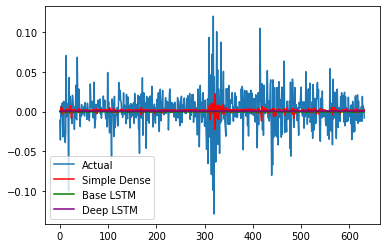

In [32]:
pred1=simple_dense.predict(Xtest)
pred2=lstm_base.predict(Xtest)
pred3=lstm2.predict(Xtest)
plt.plot(ytest)
plt.plot(pred1,color='red')
plt.plot(pred2,color='green')
plt.plot(pred3,color='purple')
plt.legend(['Actual','Simple Dense','Base LSTM','Deep LSTM'])

Based on this picture, simple dense network captures the magnitude of the variability in the returns better than both RNN's. It , however, almost always predicts the return to be negative which is of course not true in reality.

We next compute the prices from the predicted returns

In [33]:
start_test=aapl2.loc['2018-12-04'].values
predicted_price_simpledense=np.empty(633)
predicted_price_simplernn=np.empty(633)
predicted_price_deeprnn=np.empty(633)
predicted_price_simpledense[0]=start_test
predicted_price_simplernn[0]=start_test
predicted_price_deeprnn[0]=start_test

In [37]:
pred1[631]

array([0.00193755], dtype=float32)

In [43]:
for i in range(1, predicted_price_simpledense.shape[0]):
  predicted_price_simpledense[i]=predicted_price_simpledense[i-1]*(1+pred1[i-1])
for i in range(1, predicted_price_simplernn.shape[0]):
  predicted_price_simplernn[i]=predicted_price_simplernn[i-1]*(1+pred2[i-1])
for i in range(1, predicted_price_deeprnn.shape[0]):
  predicted_price_deeprnn[i]=predicted_price_deeprnn[i-1]*(1+pred3[i-1])

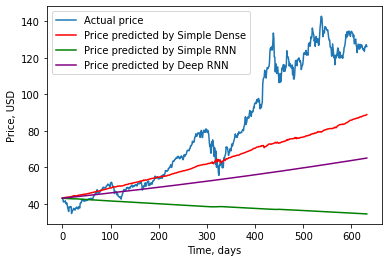

In [44]:
actual_price=aapl2.loc['2018-12-04':].values
plt.plot(actual_price)
plt.plot(predicted_price_simpledense,color='red')
plt.plot(predicted_price_simplernn,color='green')
plt.plot(predicted_price_deeprnn,color='purple')
plt.xlabel('Time, days')
plt.ylabel('Price, USD')
plt.legend(['Actual price','Price predicted by Simple Dense','Price predicted by Simple RNN','Price predicted by Deep RNN'])

Backward engineering, we see that simple RNN surprisingly fails miserably at predicting the price, while deep RNN and simple dense network capture the general upward trend and, surprisingly, simple dense does a better job.
Overall, just like in the case of classical ML algorithms neural networks are not able to predict complicated patterns in price movements and significantly underpredict the overall magnitude of price change. To be honest though, our best neural network model (simple Dense) performs slightly better than our best classical ML model (Random Forest) in both classification and regression.